<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/ToyCircleRegressionPlusUberPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#create image of circle, log values of theta or scaled [0,1]

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


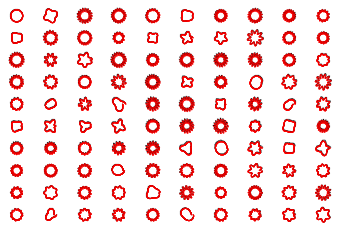

In [ ]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    #img = img.T
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            #print("sample", sample.shape)
            sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample,torch.zeros(64,1000,2).cuda())#come back to this
            #print('pred', pred.shape)
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            #print("type",type(X))
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)
        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            #print(c[(int)(el[1]),(int)(el[0])].item())
            #assert c[(int)(el[1]),(int)(el[0])].item() == 1
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [ ]:
a = torch.zeros(32,32)

a = torch.stack([a,a],dim=0)
print(a.shape)

torch.Size([2, 32, 32])


In [ ]:
"""a = dataset[1]
c = a[0]
print(a[1].shape)
for el in a[1]:
  print(c[(int)(el[1]),(int)(el[0])])"""

'a = dataset[1]\nc = a[0]\nprint(a[1].shape)\nfor el in a[1]:\n  print(c[(int)(el[1]),(int)(el[0])])'

In [ ]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = self.input_dim*10
        self.output_dim = 1000*2

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, x,points):
        x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        assert x.shape == (mini_batch,self.input_dim)
        out = self.mlp(x)
        return 32.0*out.reshape(points.shape)


In [ ]:
model = MLP().cuda()
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [ ]:
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))
optimizer = torch.optim.Adam(model.parameters(),lr = 0.000001, betas = (.9,.999))


In [ ]:

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
epoch = 300
loss = None
for e in range(epoch):
  for xin,yin in loader_train:
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    x = yin[:,:,0]
    y = yin[:,:,1]
    t = np.array([np.linspace(0,1,1000) for i in range(64)])
    z = t
    # spline parameters
    s=1 # smoothness parameter
    k=3 # spline order
    nest=-1 # estimate of number of knots needed (-1 = maximal)

    numpoints = x.shape[1]
    """scaledthetas = [(float)(i/numpoints) for i in range(numpoints)]
    scaledthetas = [scaledthetas for i in range(mini_batch)]
    scaledthetas = np.array(scaledthetas)
    scaledthetas = torch.from_numpy(scaledthetas).float().cuda()
    assert torch.max(scaledthetas) <= 1
    #print(xin.shape,scaledthetas.shape)
    out = model(xin,torch.zeros_like(scaledthetas[:,ind]),torch.zeros_like(yin[:,0,:]))
    """
    out = model(xin,yin[:,:,:2])
    #print(out.shape,yin[:2,:2,:])
    #print(yin[0,0,:])
    loss = torch.mean((out-yin[:,:,:2])**2)
    loss.backward()
    optimizer.step()
  print("epoch", e,"loss",loss.item())
    


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 loss 43.81703186035156
epoch 1 loss 45.07276916503906
epoch 2 loss 41.65119934082031
epoch 3 loss 31.681882858276367
epoch 4 loss 13.77694034576416
epoch 5 loss 24.113927841186523
epoch 6 loss 26.897903442382812
epoch 7 loss 6.647032737731934
epoch 8 loss 18.471500396728516
epoch 9 loss 28.190946578979492
epoch 10 loss 32.44694519042969
epoch 11 loss 29.90727424621582
epoch 12 loss 22.64537239074707
epoch 13 loss 13.918087005615234
epoch 14 loss 15.0626859664917
epoch 15 loss 28.579740524291992
epoch 16 loss 26.88555335998535
epoch 17 loss 13.560221672058105
epoch 18 loss 5.233475685119629
epoch 19 loss 10.203007698059082
epoch 20 loss 16.96836280822754
epoch 21 loss 21.852108001708984
epoch 22 loss 22.419498443603516
epoch 23 loss 19.328922271728516
epoch 24 loss 13.11050796508789
epoch 25 loss 6.190002918243408
epoch 26 loss 4.145810604095459
epoch 27 loss 12.191574096679688
epoch 28 loss 22.774852752685547
epoch 29 loss 27.155000686645508
epoch 30 loss 18.683103561401367
epo

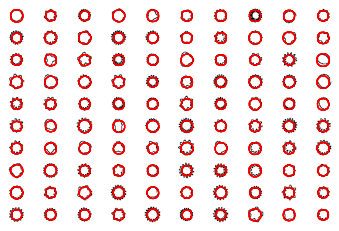

In [ ]:
DonutDataset.displayCanvas('post_train_model.png',dataset, model = model)


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
None


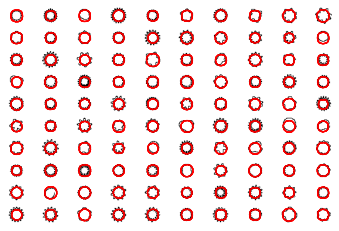

In [ ]:
xin,yin = None,None
loss = None

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('validation_set_fit.png',dataset, model = model)

print(loss)


In [ ]:

loader_val = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)
for xin,yin in loader_val:
  if xin.shape[0] != 64:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  
  out = model(xin,yin[:,:,:2])
  loss = torch.mean((out-yin[:,:,:2])**2)
  loss.backward()
  optimizer.step()
  print("validation loss",loss.item())
  break 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


validation loss 1.6671688556671143


I think I need to give the model the first x0,y0 coordinate in addition to all the other information.

Ablation:\
Network depth helps\
Network width helps\
Probably lower learning rate and long running times helps \
\
note:\
worth noting one of the ameba columns always starts at the same place

In [ ]:

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class GRU_P(nn.Module):
    def __init__(self):
        super(GRU_P, self).__init__()
        self.rnn = nn.GRU(64, 64, 64)#input, output,

        self.hiddenmlp = nn.Sequential(nn.Linear(1024,256),nn.ReLU(True),nn.Dropout(),
                                       nn.Linear(256,64),nn.ReLU(True)) 
        self.inputmlp = nn.Sequential(nn.Linear(1024,256),nn.ReLU(True),nn.Dropout(),
                                       nn.Linear(256,64),nn.ReLU(True)) 
        self.inputmlphx = nn.Sequential(nn.Linear(64,64),nn.ReLU(True),nn.Dropout(),nn.Linear(64,64),nn.Sigmoid()) 
        self.mlp = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, 2),
            nn.Sigmoid()
        )
    def forward(self, x, hidden):
        
        indim= x.shape[0]
        x = self.inputmlp(torch.flatten(x,start_dim=1))
        x = x.reshape(indim,1,64)
        hidden = hidden.reshape(indim,1024)
        hidden = self.hiddenmlp(hidden)
        #print('1')
        h = hidden.reshape(indim,1,64)
        points = torch.zeros(indim,10,2).cuda()
        for i in range(10):

          inrnn = torch.flatten(h,start_dim=1)
          #print(inrnn.shape)
          inrnn = self.inputmlphx(inrnn)
          inrnn = (x.reshape(indim,64)*inrnn.reshape(indim,64))
          out, h = self.rnn(inrnn.reshape(indim,1,64),h)
          out = self.mlp(torch.flatten(out,start_dim=1))
          points[:,i,:] = out
        #print(out.shape,h.shape)
        
        #print(h.shape)
        #assert out.shape == (indim,1,1024)
        return 32.0*points 


In [ ]:
rnn = nn.GRU(1024, 200, 2)#input, output, 
input = torch.randn(5, 1, 1024)
h0 = torch.randn(2, 1, 200)
output, hn = rnn(input, h0)
print(output.shape,hn.shape)

torch.Size([5, 1, 200]) torch.Size([2, 1, 200])


In [ ]:
model = GRU_P().cuda()
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [ ]:
#model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [ ]:
for i in range (10):
  loss = None
  for x,y in loader_train:
    x = x.cuda()
    y = y.cuda()
    out = model(x,x)
    print('1')
    #print(out.shape)
    loss = torch.mean((out-y[:,:10,:2])**2)
    loss.backward()
    optimizer.step()
    #print(y[:,0,:2])
  print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(31.3228, device='cuda:0', grad_fn=<MeanBackward0>)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(21.4646, device='cuda:0', grad_fn=<MeanBackward0>)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(7.7437, device='cuda:0', grad_fn=<MeanBackward0>)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(6.3014, device='cuda:0', grad_fn=<MeanBackward0>)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(9.0768, device='cuda:0', grad_fn=<MeanBackward0>)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(8.9183, device='cuda:0', grad_fn=<MeanBackward0>)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
tensor(6.4309, device='cuda:0', grad_fn=<MeanBackward0>)
1
1


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [ ]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class GRU_P(nn.Module):
    def __init__(self):
        super(GRU_P, self).__init__()
        self.stacks = 3
        self.rnn = nn.GRU(99, 101, self.stacks)#input, output,

        self.inputmlp = nn.Sequential(nn.Linear(1024,256),nn.ReLU(True),nn.Dropout(),
                                       nn.Linear(256,99),nn.ReLU(True)) 
        self.embedPointsMlp = nn.Sequential(nn.Linear(20+1024,512),nn.ReLU(True),nn.Dropout(),
                                       nn.Linear(512,99),nn.ReLU(True)) 
        
        self.mlp = nn.Sequential(
            nn.Linear(101, 32),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, 20),
            nn.Sigmoid()
        )
    def forward(self, x, y, h=None):
        
        indim= x.shape[0]
        if h == None:
          embed = self.embedPointsMlp(torch.cat([torch.flatten(torch.zeros(indim,20).cuda(),start_dim=1),torch.flatten(x,start_dim=1)],dim=1)).reshape(indim,1,99)
          out,h = self.rnn(embed,torch.zeros(self.stacks,1,101).cuda())
        #print(h.shape)#128,1000,3
        #print('1')
        embed = self.embedPointsMlp(torch.cat([torch.flatten(y,start_dim=1),torch.flatten(x,start_dim=1)],dim=1)).reshape(indim,1,99)
        out,h = self.rnn(embed,h)
        out = self.mlp(torch.flatten(out,start_dim=1))
        
        

        return 32.0*out , h 



In [ ]:
rnn = nn.GRU(99, 101, 3)#input, output, 
input = torch.randn(128, 1, 99)
h0 = torch.randn(3, 1, 101)
output, hn = rnn(input, h0)
print(output.shape,hn.shape)


torch.Size([128, 1, 101]) torch.Size([3, 1, 101])


In [ ]:
model = GRU_P().cuda()
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [ ]:
#model = GRU_P().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [ ]:
for i in range (10):
  loss = None
  for x,y in loader_train:
    x = x.cuda()
    y = y.cuda()
    h = None

    for i in range(1,100):
      optimizer.zero_grad()
      out,h = model(x,y[:,10*(i-1):10*(i),:2],h)
      h = h.detach()
      out = out.reshape(mini_batch,10,2)
      loss = torch.mean((out-y[:,10*i:10*(i+1),:2])**2)
      loss.backward()
      optimizer.step()
    #print(y[:,0,:2])
    print('i',i)
  print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


i 99
i 99
i 99
i 99
i 99
i 99
i 99
i 99
i 99
i 99
tensor(37.6157, device='cuda:0', grad_fn=<MeanBackward0>)
i 99
i 99
i 99
i 99
i 99
i 99
i 99
i 99
i 99
i 99
tensor(36.7172, device='cuda:0', grad_fn=<MeanBackward0>)
i 99
i 99
i 99


KeyboardInterrupt: ignored

In [ ]:
a = torch.zeros(128,111)
b = torch.zeros(128,99)
c= torch.cat([a,b],dim=1)

In [ ]:
print(c.shape)

torch.Size([128, 210])


In [ ]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        
        # define the properties
        self.embed_size = 99
        self.hidden_size = 101
        self.vocab_size = 2
        self.num_layers = 1
        # lstm cell
        self.lstm_cell = nn.LSTM(self.embed_size, self.hidden_size,self.num_layers)
    
        # output fully connected layer
        #self.mlp = 
        #self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
        self.fc_out = nn.Sequential(
            nn.Linear(101, 60),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(60, 20),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(20, 2),
            nn.Sigmoid()
        )
        # embedding layer
        #self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        #self.embed = nn

        self.inputmlp = nn.Sequential(
            nn.Linear(1024,512),nn.ReLU(),nn.Dropout(),
            nn.Linear(512,256),nn.ReLU(),nn.Dropout(),
            nn.Linear(256,97),nn.Sigmoid()) 

        self.hiddenMlp = nn.Sequential(
            nn.Linear(97+2,self.hidden_size),nn.ReLU(),nn.Dropout(),
            nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU(),nn.Dropout(),
            nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU()) 
        self.cellMlp = nn.Sequential(
            nn.Linear(97+2,self.hidden_size),nn.ReLU(),nn.Dropout(),
            nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU(),nn.Dropout(),
            nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU()) 

        
        # activations
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, features, captions):
        
        #print(features.shape,captions.shape)
        # batch size
        #print('0')
        lvector = self.inputmlp(torch.flatten(features,start_dim=1))
        p0 = torch.flatten(captions[:,0,:2],start_dim=1)

        batch_size = features.size(0)
                
        # init the hidden and cell states to zeros
        #h_0 of shape (num_layers * num_directions, batch, hidden_size)
        h0 = self.hiddenMlp(torch.cat([lvector,p0],dim=1)).reshape(self.num_layers,batch_size, self.hidden_size)
        c0 = self.cellMlp(torch.cat([lvector,p0],dim=1)).reshape(self.num_layers,batch_size, self.hidden_size)
        #hidden_state = torch.zeros((self.num_layers,batch_size, self.hidden_size)).cuda()
        #cell_state = torch.zeros((self.num_layers,batch_size, self.hidden_size)).cuda()

        #print('1')
        
        # define the output tensor placeholder
        assert captions.size(1)==1000
        assert self.vocab_size == 2
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()
        
        #output, (hidden_state, cell_state) = self.lstm_cell(features, (hidden_state, cell_state))
            
        # pass the caption word by word
        for t in range(captions.size(1)):
        
            # for the first time step the input is the feature vector
            if t == 0:
                #print('2')
        
                b = torch.cat([lvector,p0],dim=1)
                #print(b.shape)
                output, (hidden_state, cell_state) = self.lstm_cell(b.unsqueeze(0), (h0, c0))
            else:
                #print('3')
        
                pt = torch.flatten(captions[:,t-1,:2],start_dim=1)
                b = torch.cat([lvector,pt],dim=1)
                output, (hidden_state, cell_state) = self.lstm_cell(b.unsqueeze(0), (hidden_state, cell_state))
                
            out = self.fc_out(torch.flatten(torch.squeeze(output),start_dim=1))
            
            # build the output tensor
            outputs[:, t, :] = out
    
        return 32.0*outputs

In [ ]:
model = DecoderRNN().cuda()

In [ ]:
x = torch.zeros(128,1024).cuda()
y = torch.zeros(128,1000,2).cuda()

#outs = model(x,y)

In [ ]:
#model = GRU_P().cuda()
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [ ]:
#model = GRU_P().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))#ideal


In [ ]:
for i in range (20):
  loss = None
  for x,y in loader_train:
    x = x.cuda()
    y = y.cuda()
    
    optimizer.zero_grad()
    out = model(x,y[:,:,:2])
    loss = torch.mean((out-y[:,:,:2])**2)
    loss.backward()
    optimizer.step()
    #print(y[:,0,:2])
    print('i',i)
  print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
i 0
tensor(7.2511, device='cuda:0', grad_fn=<MeanBackward0>)
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
i 1
tensor(7.1782, device='cuda:0', grad_fn=<MeanBackward0>)
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
i 2
tensor(7.0582, device='cuda:0', grad_fn=<MeanBackward0>)
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
i 3
tensor(7.3243, device='cuda:0', grad_fn=<MeanBackward0>)
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
i 4
tensor(7.1884, device='cuda:0', grad_fn=<MeanBackward0>)
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
i 5
tensor(7.3165, device='cuda:0', grad_fn=<MeanBackward0>)
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
i 6
tensor(7.2381, device='cuda:0', grad_fn=<MeanBackward0>)
i 7
i 7
i 7
i 7
i 7
i 7
i 7
i 7


KeyboardInterrupt: ignored